# =============================
# Script 2 : train_mlp_on_latent.py
# =============================

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.nn.functional import normalize
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.manifold import TSNE
from data_loader_pretraining import RawDataLoader
from utils import DATA_MODALITIES, RAW_BOTH_DATA_FOLDER, BOTH_SCREENING_DATA_FOLDER, CCLE_RAW_DATA_FOLDER, CCLE_SCREENING_DATA_FOLDER, TCGA_DATA_FOLDER, TCGA_SCREENING_DATA
from mlp import MLP
from evaluation import Evaluation

# À choisir ci-dessous quel type de script utiliser : SimpleAutoencoder (MSE LOSS) vs. ZINBAutoencoder (ZINB loss)
from pretrain_autoencoders import SimpleAutoencoder
#from pretrain_autoencoders_ZINB import ZINBAutoencoder

# Utiliser le GPU si disponible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

RANDOM_SEED = 42

cpu
cpu


In [2]:
class DeepDRA_pretrained(nn.Module):

    def __init__(self, encoder_cell, encoder_drug, cell_ae_latent_dim, drug_ae_latent_dim, freeze_encoders=False):
        super(DeepDRA_pretrained, self).__init__()

        # Load pretrained encoders
        self.encoder_cell = encoder_cell.encoder
        self.encoder_drug = encoder_drug.encoder

        if freeze_encoders:
            for param in self.encoder_cell.parameters():
                param.requires_grad = False
            for param in self.encoder_drug.parameters():
                param.requires_grad = False
                
        # Initialize MLP
        self.mlp = MLP(cell_ae_latent_dim+drug_ae_latent_dim, 1)


    def forward(self, cell_x, drug_x):
        z_cell = self.encoder_cell(cell_x)
        z_drug = self.encoder_drug(drug_x)

        combined = torch.cat([z_cell, z_drug], dim=1)
        return self.mlp(combined), z_cell, z_drug

In [3]:
def DeepDRA_pretrained_training(x_cell_train, x_cell_val, x_drug_train, x_drug_val, y_train, y_val, run_id=None, visualize='first'):

    cell_ae_latent_dim = 700
    drug_ae_latent_dim = 50
    batch_size = 64

    # Convert DataFrames to Pytorch Tensors
    x_cell_train_tensor = torch.Tensor(x_cell_train.values)
    x_drug_train_tensor = torch.Tensor(x_drug_train.values)
    
    x_cell_train_tensor = torch.nn.functional.normalize(x_cell_train_tensor, dim=0)
    x_drug_train_tensor = torch.nn.functional.normalize(x_drug_train_tensor, dim=0)
    
    y_train_tensor = torch.Tensor(y_train)
    y_train_tensor = y_train_tensor.unsqueeze(1)

    # Compute class weights
    classes = np.array([0, 1])  # Assuming binary classification
    class_weights = torch.tensor(compute_class_weight(class_weight='balanced', classes=classes, y=y_train),
                                 dtype=torch.float32)

    x_cell_train_tensor, x_cell_val_tensor, x_drug_train_tensor, x_drug_val_tensor, y_train_tensor, y_val_tensor = train_test_split(
    x_cell_train_tensor, x_drug_train_tensor, y_train_tensor, test_size=0.1,
    random_state=RANDOM_SEED,
    shuffle=True)
    
    encoder_cell = SimpleAutoencoder(x_cell_train_tensor.shape[1], cell_ae_latent_dim)
    encoder_cell.load_state_dict(torch.load("encoder_cell.pth"))
    
    encoder_drug = SimpleAutoencoder(x_drug_train_tensor.shape[1], drug_ae_latent_dim)
    encoder_drug.load_state_dict(torch.load("encoder_drug.pth"))
    
    model = DeepDRA_pretrained(encoder_cell, encoder_drug, cell_ae_latent_dim, drug_ae_latent_dim, freeze_encoders=False)
    model= model.to(device)

    # Affichage du modèle
    if run_id==0:
        print("\nArchitecture du modèle:\n")
        print(model)
    
    # Create a TensorDataset with the input features and target labels
    train_dataset = TensorDataset(x_cell_train_tensor.to(device), x_drug_train_tensor.to(device), y_train_tensor.to(device))
    val_dataset = TensorDataset(x_cell_val_tensor.to(device), x_drug_val_tensor.to(device), y_val_tensor.to(device))

    # Create the train_loader and val_loader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    
    # Train the model
    train_mlp_with_encoders(model, train_loader, val_loader, class_weights, run_id=run_id)

    # sparcity
    with torch.no_grad():
        z_cell = encoder_cell.encoder(x_cell_train_tensor)
        z_drug = encoder_drug.encoder(x_drug_train_tensor)

    # T-SNE (never / first / always)
    if visualize == 'always' or (visualize == 'first' and run_id == 0):
        def plot_tsne(z_tensor, y_tensor, title):
            z_embedded = TSNE(n_components=2, random_state=42).fit_transform(z_tensor.cpu().numpy())
            y_np = y_tensor.cpu().numpy().ravel()
            plt.figure(figsize=(8, 6))
            for label, color in zip([0, 1], ['blue', 'red']):
                plt.scatter(z_embedded[y_np == label, 0], z_embedded[y_np == label, 1],
                            label='Resistant' if label == 0 else 'Sensitive',
                            c=color, alpha=0.7)
            plt.title(title)
            plt.legend()
            plt.tight_layout()
            plt.show()

        plot_tsne(z_cell, y_train_tensor, "t-SNE - z_cell")
        plot_tsne(z_drug, y_train_tensor, "t-SNE - z_drug")
        plot_tsne(torch.cat([z_cell, z_drug], dim=1), y_train_tensor, "t-SNE - z_cell + z_drug")

    return model

def train_mlp_with_encoders(model, train_loader, val_loader, class_weights, epochs=25, run_id=0):

    mlp_optimizer = optim.Adam(model.parameters(), lr=0.0005)
    scheduler = lr_scheduler.ReduceLROnPlateau(mlp_optimizer, mode='min', factor=0.8, patience=5, verbose=True)
    mlp_loss_fn = nn.BCELoss()

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0.0
        train_preds = []
        train_targets = []
        for batch_idx, (cell_data, drug_data, target) in enumerate(train_loader):
            mlp_optimizer.zero_grad()
            y_pred, _, _ = model(cell_data, drug_data)
            loss = mlp_loss_fn(y_pred, target)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            mlp_optimizer.step()
            total_train_loss += loss.item()

            # Collect predictions and targets for accuracy
            train_preds.extend((y_pred > 0.5).cpu().numpy())
            train_targets.extend(target.cpu().numpy())

        train_acc = np.mean(np.array(train_preds) == np.array(train_targets))
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        total_val_loss = 0.0
        val_preds = []
        val_targets = []
        
        with torch.no_grad():
            for val_batch_idx, (cell_data_val, drug_data_val, val_target) in enumerate(val_loader):
                y_val_pred, _, _ = model(cell_data_val, drug_data_val)
                val_loss = mlp_loss_fn(y_val_pred, val_target)
                total_val_loss += val_loss.item()

                val_preds.extend((y_val_pred > 0.5).cpu().numpy())
                val_targets.extend(val_target.cpu().numpy())

        val_acc = np.mean(np.array(val_preds) == np.array(val_targets))
        val_accuracies.append(val_acc)

        train_losses.append(total_train_loss / len(train_loader))
        val_losses.append(total_val_loss / len(val_loader))
        
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")
        
        scheduler.step(total_val_loss / len(val_loader))

    # Plot losses and accuracies
    Evaluation.plot_train_val_loss(train_losses, val_losses, epochs)
    Evaluation.plot_train_val_accuracy(train_accuracies, val_accuracies, epochs)

    # Save each models
    torch.save(model.encoder_cell, f"encoder_cell_trained_run_{run_id}.pt")
    torch.save(model.encoder_drug, f"encoder_drug_trained_run_{run_id}.pt")
    torch.save(model.mlp.state_dict(), f"mlp_trained_run_{run_id}.pth")
    
    return model

def test(model, test_loader):
    model.eval()
    
    for test_cell_loader, test_drug_loader, labels in test_loader:
        # Forward pass through the model
        with torch.no_grad():
            y_pred, _, _ = model(test_cell_loader, test_drug_loader)

    result = Evaluation.evaluate(labels, y_pred)
    return result


In [4]:
def cv_train(x_cell_train, x_drug_train, y_train, device, k=3, run_id=None, visualize='first'):


    splits = KFold(n_splits=k, shuffle=True, random_state=RANDOM_SEED)
    history = {'AUC': [], 'AUPRC': [], "Accuracy": [], "Precision": [], "Recall": [], "F1 score": []}
    
    cell_ae_latent_dim = 700
    drug_ae_latent_dim = 50
    batch_size = 64

    for fold, (train_idx, val_idx) in enumerate(splits.split(np.arange(len(x_cell_train)))):
        print('Fold {}'.format(fold + 1))

        train_sampler = SubsetRandomSampler(train_idx)
        test_sampler = SubsetRandomSampler(val_idx)

            # Convert your training data to PyTorch tensors
        x_cell_train_tensor = torch.Tensor(x_cell_train.values)
        x_drug_train_tensor = torch.Tensor(x_drug_train.values)

        y_train_tensor = torch.Tensor(y_train)
        y_train_tensor = y_train_tensor.unsqueeze(1)
        
        x_cell_train_tensor = torch.nn.functional.normalize(x_cell_train_tensor, dim=0)
        x_drug_train_tensor = torch.nn.functional.normalize(x_drug_train_tensor, dim=0)

        # Compute class weights
        classes = np.array([0, 1])  # Assuming binary classification
        class_weights = torch.tensor(compute_class_weight(class_weight='balanced', classes=classes, y=y_train),
                                     dtype=torch.float32)

        encoder_cell = SimpleAutoencoder(x_cell_train_tensor.shape[1], cell_ae_latent_dim)
        encoder_cell.load_state_dict(torch.load("encoder_cell.pth"))
        
        encoder_drug = SimpleAutoencoder(x_drug_train_tensor.shape[1], drug_ae_latent_dim)
        encoder_drug.load_state_dict(torch.load("encoder_drug.pth"))
        
        model = DeepDRA_pretrained(encoder_cell, encoder_drug, cell_ae_latent_dim, drug_ae_latent_dim, freeze_encoders=False)
        model = model.to(device)
      
        # Create a TensorDataset with the input features and target labels
        train_dataset = TensorDataset(x_cell_train_tensor.to(device), x_drug_train_tensor.to(device), y_train_tensor.to(device))

        # Create the train_loader AND val_loader
        train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
        val_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=test_sampler)
        
        # Train the model
        train_mlp_with_encoders(model, train_loader, val_loader, class_weights)

        # Create a TensorDataset with the input features and target labels
        test_loader = DataLoader(train_dataset, batch_size=len(x_cell_train), sampler=test_sampler)

        # Test the model
        results = test(model, test_loader)

        # Step 10: Add results to the history dictionary
        Evaluation.add_results(history, results)


        # sparcity
        with torch.no_grad():
            z_cell = encoder_cell.encoder(x_cell_train_tensor)
            z_drug = encoder_drug.encoder(x_drug_train_tensor)
        
        # T-SNE (never / first / always)
        if visualize == 'always' or (visualize == 'first' and run_id == 0):
            def plot_tsne(z_tensor, y_tensor, title):
                z_embedded = TSNE(n_components=2, random_state=42).fit_transform(z_tensor.cpu().numpy())
                y_np = y_tensor.cpu().numpy().ravel()
                plt.figure(figsize=(8, 6))
                for label, color in zip([0, 1], ['blue', 'red']):
                    plt.scatter(z_embedded[y_np == label, 0], z_embedded[y_np == label, 1],
                                label='Resistant' if label == 0 else 'Sensitive',
                                c=color, alpha=0.7)
                plt.title(title)
                plt.legend()
                plt.tight_layout()
                plt.show()
    
            plot_tsne(z_cell, y_train_tensor, "t-SNE - z_cell")
            plot_tsne(z_drug, y_train_tensor, "t-SNE - z_drug")
            plot_tsne(torch.cat([z_cell, z_drug], dim=1), y_train_tensor, "t-SNE - z_cell + z_drug")

    return history

Reading Raw Data Files...:   0%|                                                                 | 0/6 [00:00<?, ?it/s]C:\Users\camil\IMAG\DeepDRA\data_loader_pretraining.py:160: FutureWarning: Index.is_numeric is deprecated. Use pandas.api.types.is_any_real_numeric_dtype instead
  if df.index.is_numeric():
Reading Raw Data Files...:  33%|███████████████████                                      | 2/6 [00:24<00:48, 12.15s/it]C:\Users\camil\IMAG\DeepDRA\data_loader_pretraining.py:160: FutureWarning: Index.is_numeric is deprecated. Use pandas.api.types.is_any_real_numeric_dtype instead
  if df.index.is_numeric():
Reading Raw Data Files...:   0%|                                                                 | 0/8 [00:00<?, ?it/s]C:\Users\camil\IMAG\DeepDRA\data_loader_pretraining.py:160: FutureWarning: Index.is_numeric is deprecated. Use pandas.api.types.is_any_real_numeric_dtype instead
  if df.index.is_numeric():
C:\Users\camil\IMAG\DeepDRA\data_loader_pretraining.py:160: FutureWarning

train_data when loaded: dict_keys(['cell_exp', 'cell_mut', 'drug_desc', 'drug_finger'])
cell_exp: (373, 19221)
cell_mut: (373, 17671)
drug_desc: (690, 209)
drug_finger: (690, 4048)


Reading Raw Data Files...:   0%|                                                                 | 0/4 [00:00<?, ?it/s]C:\Users\camil\IMAG\DeepDRA\data_loader_pretraining.py:160: FutureWarning: Index.is_numeric is deprecated. Use pandas.api.types.is_any_real_numeric_dtype instead
  if df.index.is_numeric():
Reading Raw Data Files...:  50%|████████████████████████████▌                            | 2/4 [00:07<00:07,  3.51s/it]C:\Users\camil\IMAG\DeepDRA\data_loader_pretraining.py:160: FutureWarning: Index.is_numeric is deprecated. Use pandas.api.types.is_any_real_numeric_dtype instead
  if df.index.is_numeric():
Reading Raw Data Files...:   0%|                                                                 | 0/8 [00:00<?, ?it/s]C:\Users\camil\IMAG\DeepDRA\data_loader_pretraining.py:160: FutureWarning: Index.is_numeric is deprecated. Use pandas.api.types.is_any_real_numeric_dtype instead
  if df.index.is_numeric():
C:\Users\camil\IMAG\DeepDRA\data_loader_pretraining.py:160: FutureWarning

test_data when loaded: dict_keys(['cell_exp', 'cell_mut', 'drug_desc', 'drug_finger'])
cell_exp: (664, 17737)
cell_mut: (664, 15009)
drug_desc: (32, 209)
drug_finger: (32, 4048)
Preparing data...
sensitive train data len: 1895
resistance train data len: 4641
Preparing data...
sensitive train data len: 573
resistance train data len: 377
x_cell_train shape: (3790, 30879)
x_drug_train shape: (3790, 4257)
x_cell_test shape: (950, 30879)
x_drug_test shape: (950, 4257)
Distribution des classes : Counter({np.float64(0.0): 1895, np.float64(1.0): 1895})

Run 1/3

Architecture du modèle:

DeepDRA_pretrained(
  (encoder_cell): Sequential(
    (0): Linear(in_features=30879, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=256, out_features=700, bias=True)
  )
  (encoder_drug): Sequential(
    (0): Linear(in_features=4257, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.1, inplace=False)
    (3)

C:\Users\camil\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/25], Train Loss: 0.6118, Val Loss: 0.3942
Epoch [2/25], Train Loss: 0.2681, Val Loss: 0.2279
Epoch [3/25], Train Loss: 0.1277, Val Loss: 0.1963
Epoch [4/25], Train Loss: 0.1123, Val Loss: 0.1583
Epoch [5/25], Train Loss: 0.0778, Val Loss: 0.1484
Epoch [6/25], Train Loss: 0.0737, Val Loss: 0.1652
Epoch [7/25], Train Loss: 0.0637, Val Loss: 0.1466
Epoch [8/25], Train Loss: 0.0638, Val Loss: 0.1484
Epoch [9/25], Train Loss: 0.0525, Val Loss: 0.1619
Epoch [10/25], Train Loss: 0.0505, Val Loss: 0.1501
Epoch [11/25], Train Loss: 0.0515, Val Loss: 0.1852
Epoch [12/25], Train Loss: 0.0472, Val Loss: 0.1630
Epoch [13/25], Train Loss: 0.0405, Val Loss: 0.1800
Epoch [14/25], Train Loss: 0.0376, Val Loss: 0.1740
Epoch [15/25], Train Loss: 0.0376, Val Loss: 0.1891
Epoch [16/25], Train Loss: 0.0351, Val Loss: 0.1767
Epoch [17/25], Train Loss: 0.0284, Val Loss: 0.1724
Epoch [18/25], Train Loss: 0.0336, Val Loss: 0.1946
Epoch [19/25], Train Loss: 0.0284, Val Loss: 0.1861
Epoch [20/25], Train 

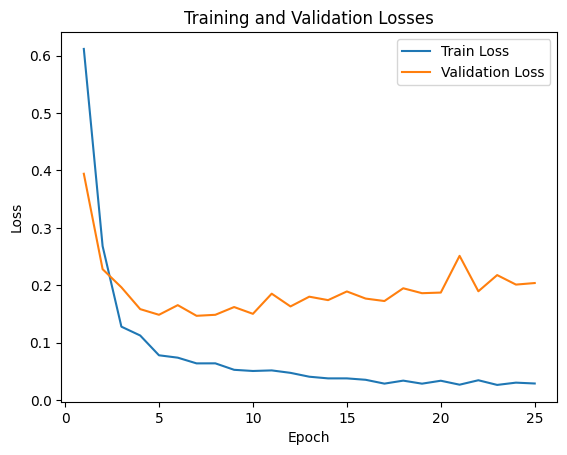

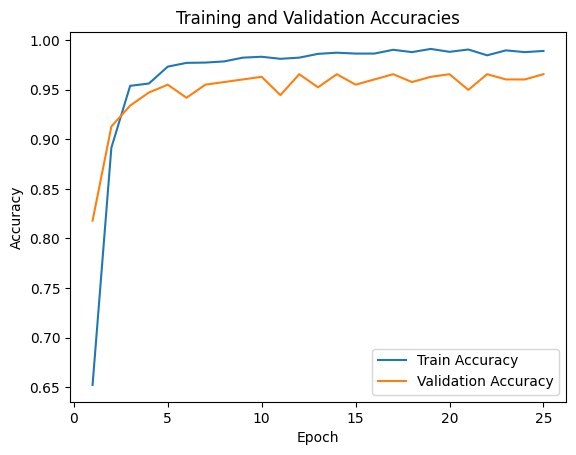

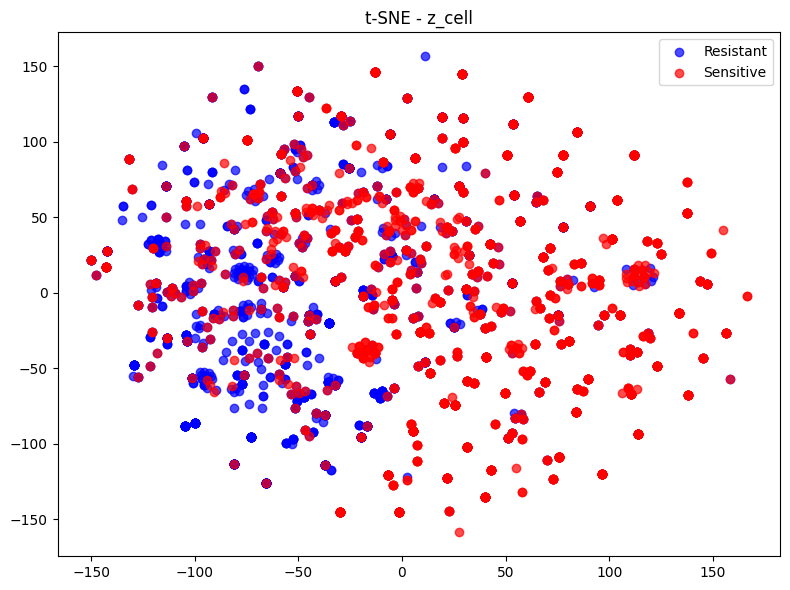

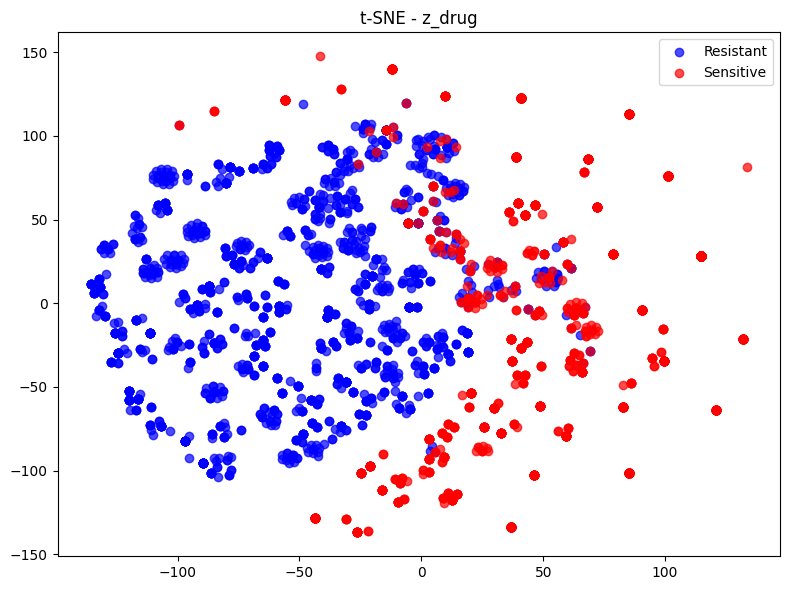

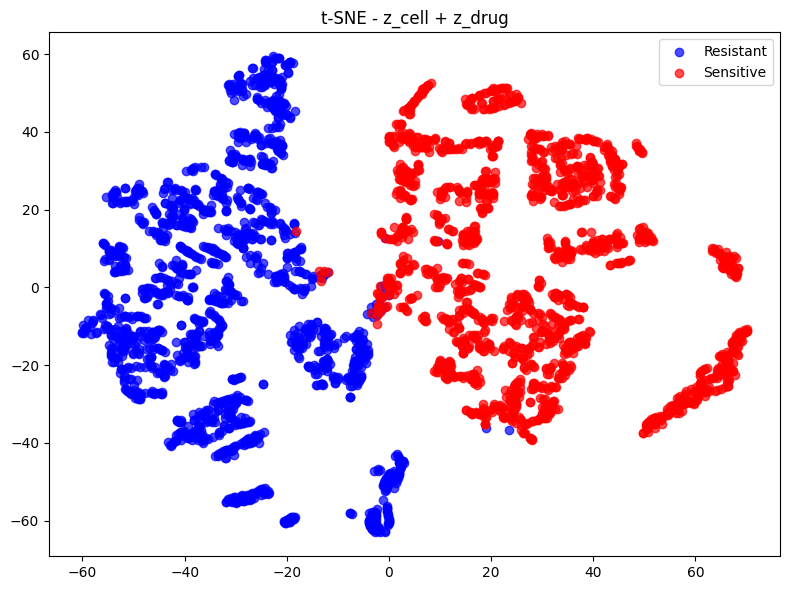

Confusion matrix:
[[165 212]
 [255 318]]
Accuracy: 0.508, Precision: 0.438, Recall: 0.393, F1 score: 0.414, AUC: 0.535, ,AUPRC: 0.602

Run 2/3


C:\Users\camil\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/25], Train Loss: 0.5825, Val Loss: 0.3643
Epoch [2/25], Train Loss: 0.2364, Val Loss: 0.2059
Epoch [3/25], Train Loss: 0.1344, Val Loss: 0.1676
Epoch [4/25], Train Loss: 0.0961, Val Loss: 0.1624
Epoch [5/25], Train Loss: 0.0795, Val Loss: 0.1416
Epoch [6/25], Train Loss: 0.0642, Val Loss: 0.1458
Epoch [7/25], Train Loss: 0.0561, Val Loss: 0.1571
Epoch [8/25], Train Loss: 0.0568, Val Loss: 0.1532
Epoch [9/25], Train Loss: 0.0474, Val Loss: 0.1570
Epoch [10/25], Train Loss: 0.0429, Val Loss: 0.1721
Epoch [11/25], Train Loss: 0.0420, Val Loss: 0.1857
Epoch [12/25], Train Loss: 0.0518, Val Loss: 0.1598
Epoch [13/25], Train Loss: 0.0372, Val Loss: 0.1578
Epoch [14/25], Train Loss: 0.0347, Val Loss: 0.1669
Epoch [15/25], Train Loss: 0.0372, Val Loss: 0.1703
Epoch [16/25], Train Loss: 0.0364, Val Loss: 0.1793
Epoch [17/25], Train Loss: 0.0343, Val Loss: 0.1763
Epoch [18/25], Train Loss: 0.0303, Val Loss: 0.1720
Epoch [19/25], Train Loss: 0.0396, Val Loss: 0.1786
Epoch [20/25], Train 

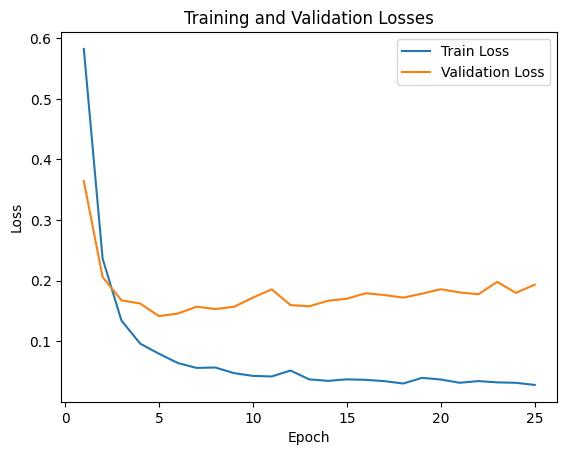

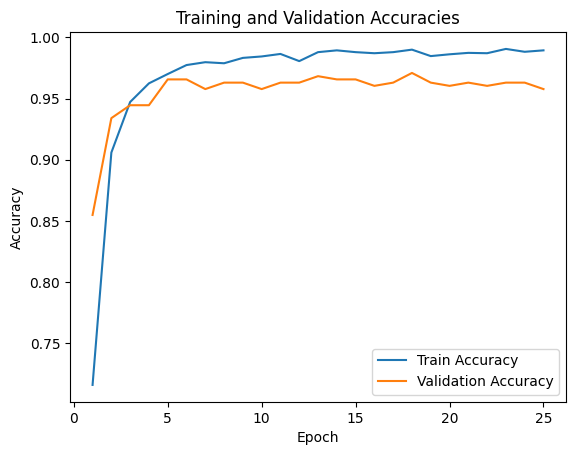

Confusion matrix:
[[169 208]
 [255 318]]
Accuracy: 0.513, Precision: 0.448, Recall: 0.399, F1 score: 0.422, AUC: 0.534, ,AUPRC: 0.609

Run 3/3


C:\Users\camil\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/25], Train Loss: 0.5833, Val Loss: 0.3646
Epoch [2/25], Train Loss: 0.2481, Val Loss: 0.2198
Epoch [3/25], Train Loss: 0.1290, Val Loss: 0.1689
Epoch [4/25], Train Loss: 0.0951, Val Loss: 0.2345
Epoch [5/25], Train Loss: 0.0977, Val Loss: 0.1451
Epoch [6/25], Train Loss: 0.0679, Val Loss: 0.1424
Epoch [7/25], Train Loss: 0.0538, Val Loss: 0.1510
Epoch [8/25], Train Loss: 0.0542, Val Loss: 0.1353
Epoch [9/25], Train Loss: 0.0556, Val Loss: 0.1367
Epoch [10/25], Train Loss: 0.0455, Val Loss: 0.1535
Epoch [11/25], Train Loss: 0.0479, Val Loss: 0.1480
Epoch [12/25], Train Loss: 0.0443, Val Loss: 0.1636
Epoch [13/25], Train Loss: 0.0412, Val Loss: 0.1689
Epoch [14/25], Train Loss: 0.0368, Val Loss: 0.1810
Epoch [15/25], Train Loss: 0.0423, Val Loss: 0.1643
Epoch [16/25], Train Loss: 0.0480, Val Loss: 0.1629
Epoch [17/25], Train Loss: 0.0372, Val Loss: 0.1682
Epoch [18/25], Train Loss: 0.0333, Val Loss: 0.1725
Epoch [19/25], Train Loss: 0.0337, Val Loss: 0.1741
Epoch [20/25], Train 

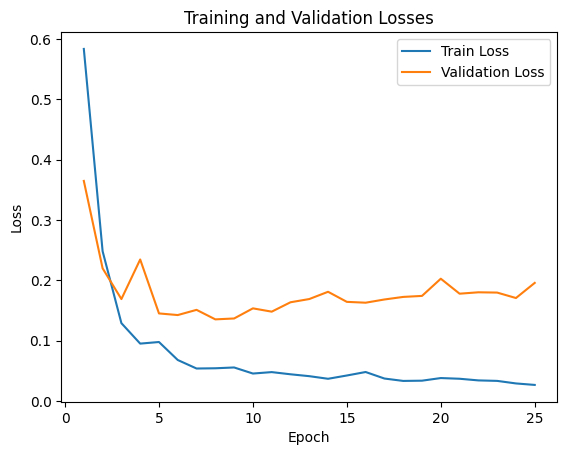

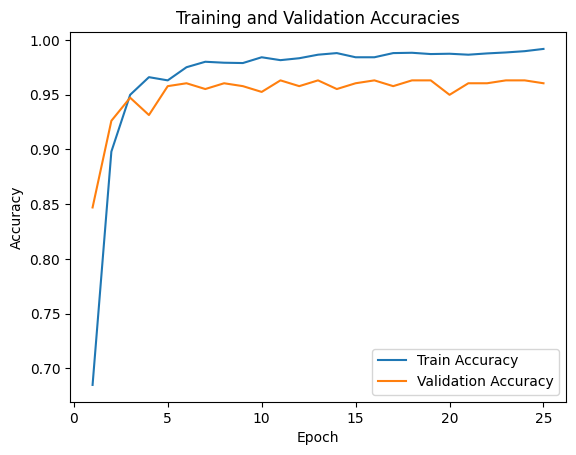

Confusion matrix:
[[164 213]
 [256 317]]
Accuracy: 0.506, Precision: 0.435, Recall: 0.390, F1 score: 0.412, AUC: 0.528, ,AUPRC: 0.606
Final Results:
AVG: Accuracy: 0.509, Precision: 0.440, Recall: 0.394, F1 score: 0.416, AUC: 0.532, ,AUPRC: 0.606
 Average AUC: 0.532 	 Average AUPRC: 0.606 	 Std AUPRC: 0.003


In [5]:
def run(k=10, is_test=False, visualize='first'):
    
    # Initialisation de l'historique des métriques
    history = {'AUC': [], 'AUPRC': [], "Accuracy": [], "Precision": [], "Recall": [], "F1 score": []}
    
    # Load training data
    train_data, train_drug_screen = RawDataLoader.load_data(
        data_modalities=DATA_MODALITIES,
        raw_file_directory=RAW_BOTH_DATA_FOLDER,
        screen_file_directory=BOTH_SCREENING_DATA_FOLDER,
        sep="\t"
    )

    print('train_data when loaded:', train_data.keys())
    for key, df in train_data.items():
        print(f"{key}: {df.shape}")
    
    # Load test data if applicable
    if is_test:
        test_data, test_drug_screen = RawDataLoader.load_data(
            data_modalities=DATA_MODALITIES,
            raw_file_directory=TCGA_DATA_FOLDER,  
            screen_file_directory=TCGA_SCREENING_DATA,
            sep="\t"
        )

        print('test_data when loaded:', test_data.keys())
        for key, df in test_data.items():
            print(f"{key}: {df.shape}")
                
        # Intersection des features entre train et test
        train_data, test_data = RawDataLoader.data_features_intersect(train_data, test_data)

        # Save the feature columns for reproducibility:
        all_features = {}
        for key, df in train_data.items():
            all_features[key] = df.columns.tolist()
        
        import pickle
        with open("feature_columns.pkl", "wb") as f:
            pickle.dump(all_features, f)

    # Prepare input data for training
    x_cell_train, x_drug_train, y_train, cell_sizes, drug_sizes = RawDataLoader.prepare_input_data(train_data, train_drug_screen)

    if is_test:
        x_cell_test, x_drug_test, y_test, cell_sizes, drug_sizes = RawDataLoader.prepare_input_data(test_data, test_drug_screen)

    # Application d'un sous-échantillonnage pour équilibrer la classe majoritaire    
    rus = RandomUnderSampler(sampling_strategy="majority", random_state=42)
    dataset = pd.concat([x_cell_train, x_drug_train], axis=1)
    dataset.index = x_cell_train.index
    dataset, y_train = rus.fit_resample(dataset, y_train)
    x_cell_train = dataset.iloc[:, :sum(cell_sizes)]
    x_drug_train = dataset.iloc[:, sum(cell_sizes):]

    print('x_cell_train shape:', x_cell_train.shape)
    print('x_drug_train shape:', x_drug_train.shape)
    
    if is_test:
        print('x_cell_test shape:', x_cell_test.shape)
        print('x_drug_test shape:', x_drug_test.shape)

    from collections import Counter
    print("Distribution des classes :", Counter(y_train))

    for i in range(k):
        print(f"\nRun {i+1}/{k}")

        # If is_test is True, perform random under-sampling on the training data
        if is_test:
            
            # Train and evaluate the DeepDRA model on test data
            model = DeepDRA_pretrained_training(x_cell_train, x_cell_test, x_drug_train, x_drug_test, y_train, y_test, run_id=i, visualize=visualize)
            
            # Convert your test data to PyTorch tensors
            x_cell_test_tensor = torch.Tensor(x_cell_test.values)
            x_drug_test_tensor = torch.Tensor(x_drug_test.values)
            y_test_tensor = torch.Tensor(y_test).to(device)
        
            # normalize data
            x_cell_test_tensor = torch.nn.functional.normalize(x_cell_test_tensor, dim=0).to(device)
            x_drug_test_tensor = torch.nn.functional.normalize(x_drug_test_tensor, dim=0).to(device)
        
            # Create a TensorDataset with the input features and target labels for testing
            test_dataset = TensorDataset(x_cell_test_tensor, x_drug_test_tensor, y_test_tensor)
            test_loader = DataLoader(test_dataset, batch_size=len(x_cell_test))

            results = test(model, test_loader)

        else:

            # Train and evaluate the DeepDRA model on the split data
            results = cv_train(x_cell_train, x_drug_train, y_train, device, run_id=i, visualize=visualize)

        # Ajout des métriques du run courant à l'historique
        Evaluation.add_results(history, results)

    # Display final results
    Evaluation.show_final_results(history)
    return history

if __name__ == "__main__":
    torch.manual_seed(RANDOM_SEED)
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    run(k=3, is_test=True)